In [1]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

pd.set_option("display.max_columns", None)

import argparse

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import Tensor
from typing import List, Tuple, Optional
from pandas import DataFrame
from argparse import Namespace
from sklearn.model_selection import train_test_split
import scanpy as sc

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from sklearn.preprocessing import LabelEncoder


# Note: only preprosessing, which keeps 0 as 0 is allowed if we want to 0 mean no expression
def prepare_data(
    val_frac: float,
    divide_by_nonzero_median: bool,
    df_columns: List[str],
    random_state: int = 0,
    return_raw: bool = False,
) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, LabelEncoder]:
    data = data_utils.load_anndata(mode="train", plus_iid_holdout=True, normalize=False)
    sc.pp.log1p(data)
    data = data[data.obs["is_train"].apply(lambda x: x in ["train", "iid_holdout"])]

    tensor_data = torch.tensor(data.X.todense(), dtype=torch.float32, device=device)
    raw = data.layers["counts"]
    df = pd.DataFrame(data.obs[df_columns])
    del data

    if divide_by_nonzero_median:
        nonzero_median = tensor_data[tensor_data > 0].median(dim=0, keepdim=True).values
        tensor_data = tensor_data / nonzero_median
        del nonzero_median

    train_tensor_data, val_tensor_data, train_df, val_df, train_raw, val_raw = (
        train_test_split(
            tensor_data, df, raw, test_size=val_frac, random_state=random_state
        )
    )

    if return_raw:
        return train_tensor_data, val_tensor_data, train_df, val_df, train_raw, val_raw

    return train_tensor_data, val_tensor_data, train_df, val_df

In [ ]:
train_tensor_data, val_tensor_data, train_df, val_df, train_raw, val_raw = prepare_data(
    val_frac=0.1,
    divide_by_nonzero_median=True,
    df_columns=["cell_type", "batch", "Site", "DonorNumber"],
    return_raw=True,
)

/home/prz/bioml/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Subsampling anndata with fraction 1.0...


/home/prz/bioml/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
def draw_umaps_pca(data_tensor: Tensor, df: DataFrame) -> None:
    r"""
    Computes pca and draws umaps for each column in df.
    """
    ad_tmp = ad.AnnData(X=data_tensor.numpy(), obs=df)
    sc.pp.pca(ad_tmp, n_comps=20)
    sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X_pca")
    sc.tl.umap(ad_tmp)

    for col_name in df.columns:
        sc.pl.umap(ad_tmp, color=col_name)

    for col_name in df.columns:
        sc.pl.pca(ad_tmp, color=col_name)

## PCA UMAP reference

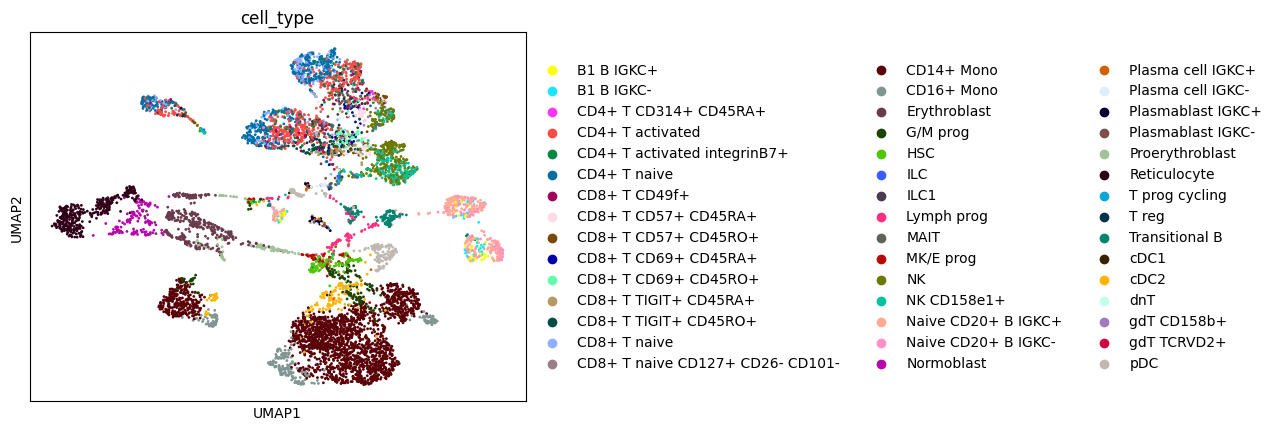

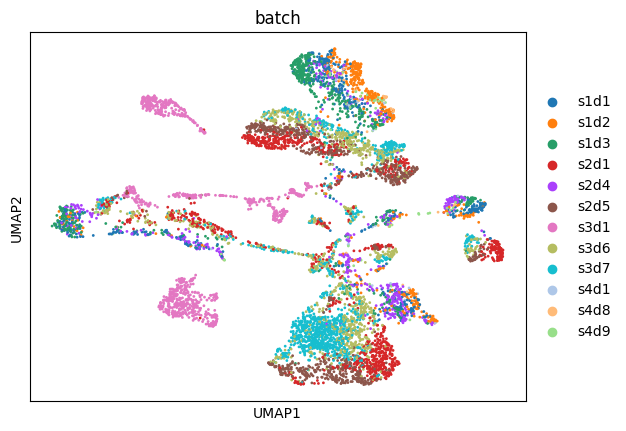

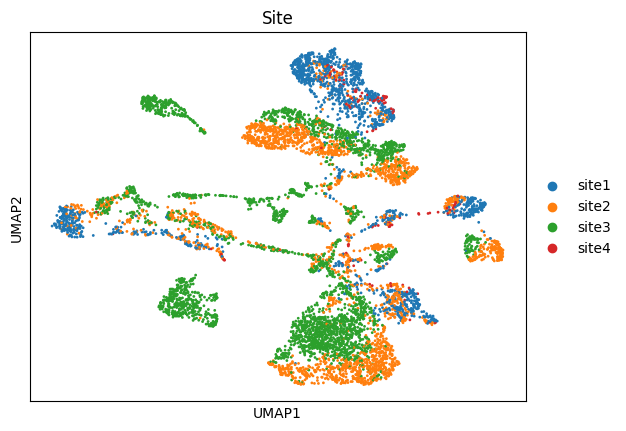

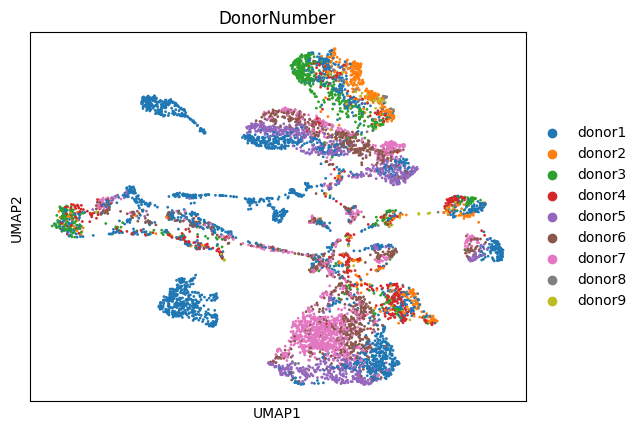

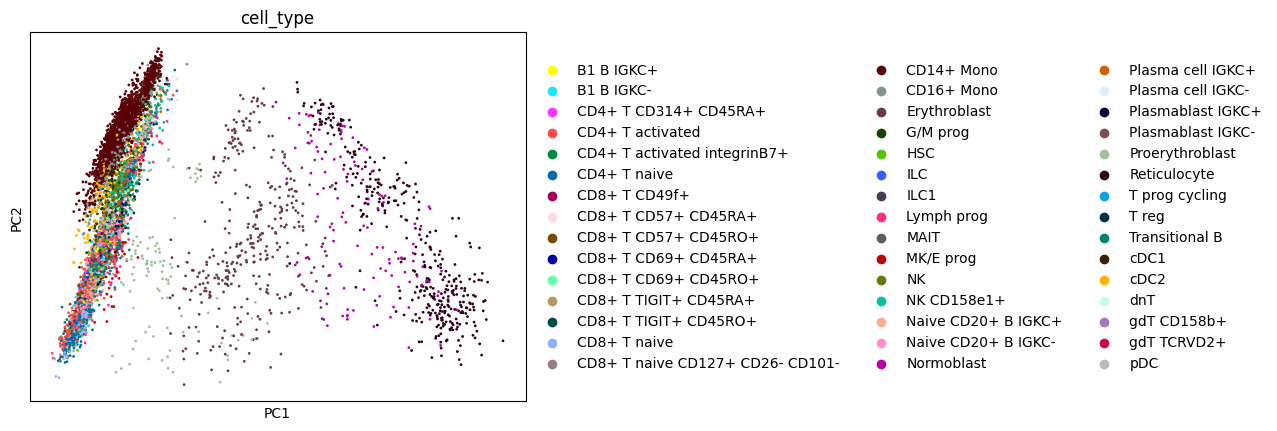

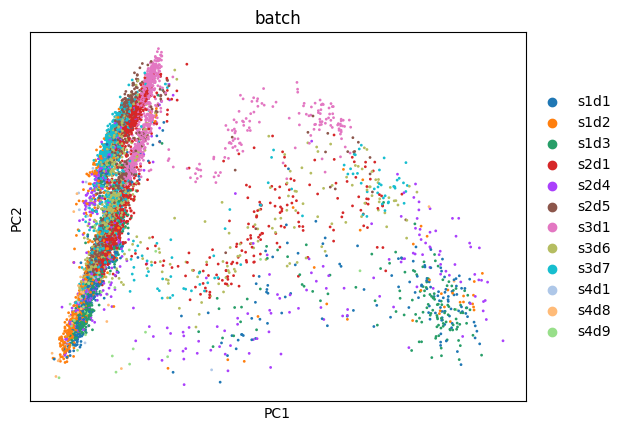

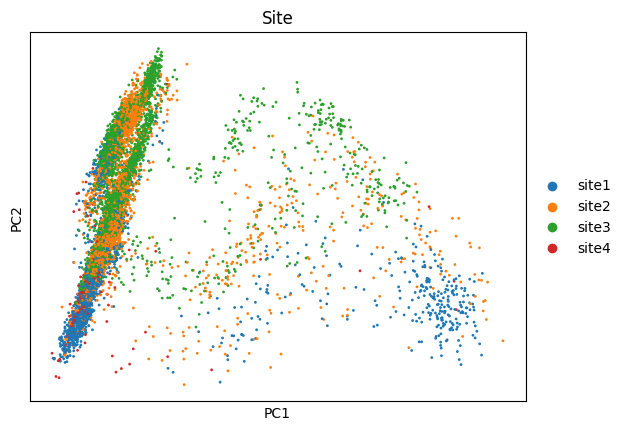

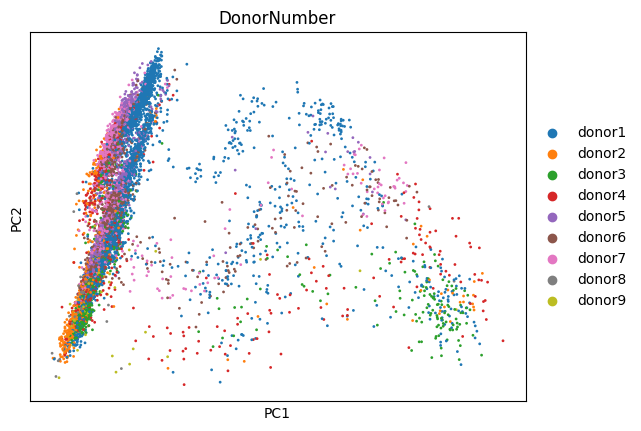

In [13]:
draw_umaps_pca(val_tensor_data, val_df)

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self, latent_dims, hidden_dims, input_dims, dropout
    ):  # dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            # nn.Dropout(p=dropout),
            # nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            # nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, latent_dims),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded


class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            # nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, input_dims),
        )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded

In [ ]:
def dict_to_namespace(d):
    r"""
    Recursively converts a dictionary into a Namespace object.
    """
    for key, value in d.items():
        if isinstance(value, dict):
            d[key] = dict_to_namespace(value)
    return Namespace(**d)

In [ ]:
def get_data_embeddings(
    tensor_dataset: torch.utils.data.TensorDataset, model
) -> Tuple[Tensor, Tensor]:
    dataloader = torch.utils.data.DataLoader(
        tensor_dataset, batch_size=128, shuffle=False
    )
    embeddings = []
    for x in dataloader:
        x = x[0]
        encoded = model.encoder(x)
        embeddings.append(encoded)
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

## Just torch

In [ ]:
class AE(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout):
        super(AE, self).__init__()
        self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout)
        self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def validate(model, val_dataloader):
    model.eval()
    sum_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            x = data[0].to(device)
            x_hat = model(x)
            loss = F.mse_loss(x_hat, x)
            sum_loss += loss.item()
    print(f"Validation Loss: {sum_loss/len(val_dataloader)}")
    return sum_loss / len(val_dataloader)


def train(model, train_dataloader, val_dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, data in enumerate(train_dataloader):
            optimizer.zero_grad()
            x = data[0].to(device)
            x_hat = model(x)
            loss = F.mse_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {sum_loss/len(train_dataloader)}")
        val_loss = validate(model, val_dataloader)

In [ ]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "num_genes": 14087,
        "gene_embedding_dim": 8,
        "embedding_dim": 100,
        "latent_dim": 20,
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "lr": 1e-3,
        },
        "n_epochs": 10,
    },
}

cfg = dict_to_namespace(cfg_dict)

In [ ]:
train_tensor_dataset = torch.utils.data.TensorDataset(train_tensor_data)
train_loader = torch.utils.data.DataLoader(
    train_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=True
)
val_tensor_dataset = torch.utils.data.TensorDataset(val_tensor_data)
val_loader = torch.utils.data.DataLoader(
    val_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=False
)

### Training

In [ ]:
model = AE(cfg.model.latent_dim, cfg.model.embedding_dim, cfg.model.num_genes, 0.05).to(
    device
)
train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=cfg.training.optimizer.lr),
    epochs=cfg.training.n_epochs,
)

Epoch 1, Loss: 0.104514159966394
Validation Loss: 0.09347861228605449
Epoch 2, Loss: 0.09265541102180859
Validation Loss: 0.09080219540303036
Epoch 3, Loss: 0.09099042536743647
Validation Loss: 0.08950489835213807
Epoch 4, Loss: 0.09002828364927737
Validation Loss: 0.08890460905129627
Epoch 5, Loss: 0.08952135349745335
Validation Loss: 0.08848819635429625
Epoch 6, Loss: 0.08913336698465853
Validation Loss: 0.08811115025211189
Epoch 7, Loss: 0.08882876776426411
Validation Loss: 0.08792782549635839
Epoch 8, Loss: 0.08858229150900543
Validation Loss: 0.08776149387329311
Epoch 9, Loss: 0.08837999057003591
Validation Loss: 0.08756245559049865
Epoch 10, Loss: 0.08820798979730597
Validation Loss: 0.08745578051371089


## PCA UMAP reference

## Checking pearson residuals applied just on the validation dataset

In [12]:
ad_tmp = ad.AnnData(X=val_raw, obs=val_df)
sc.experimental.pp.normalize_pearson_residuals(ad_tmp)

In [23]:
ad_tmp

AnnData object with n_obs × n_vars = 7520 × 14087
    obs: 'cell_type', 'batch', 'Site', 'DonorNumber'
    uns: 'pearson_residuals_normalization', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'Site_colors', 'DonorNumber_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
sc.pp.pca(ad_tmp, n_comps=20)
sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X_pca")
sc.tl.umap(ad_tmp)

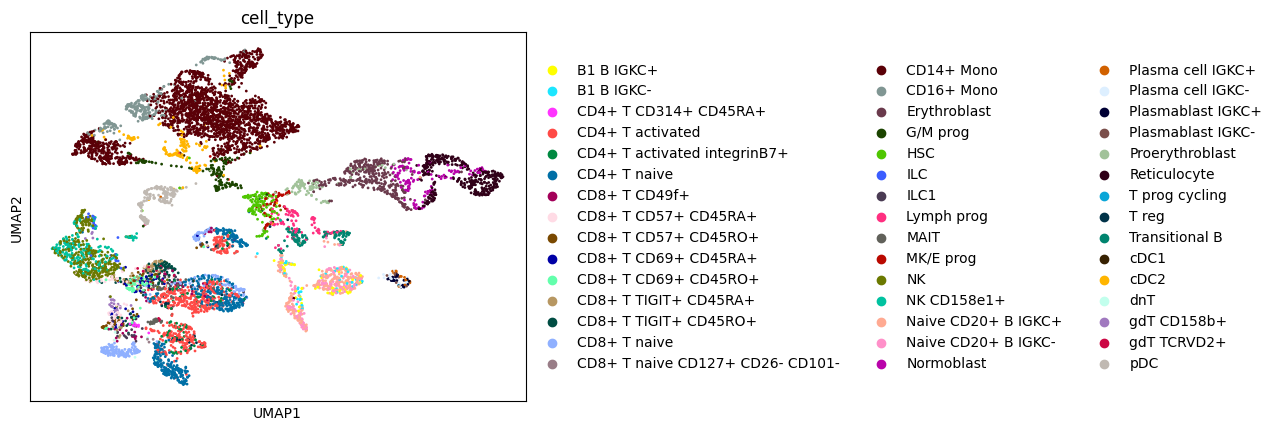

In [24]:
sc.pl.umap(ad_tmp, color="cell_type")

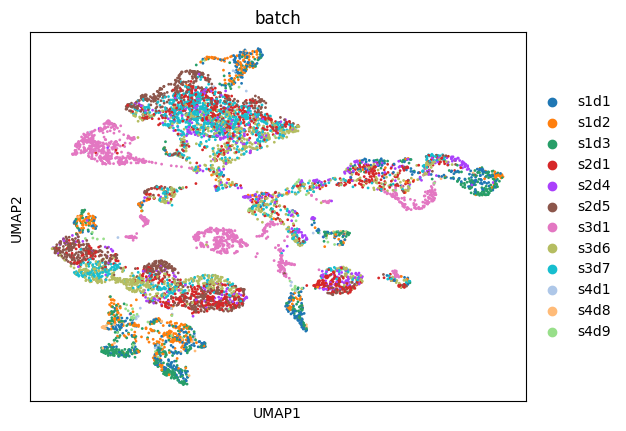

In [20]:
sc.pl.umap(ad_tmp, color="batch")

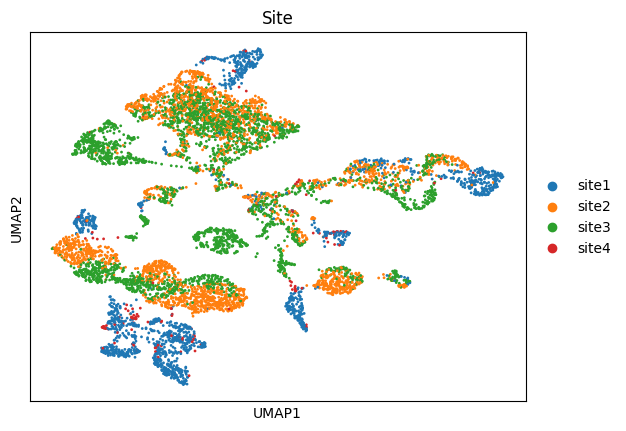

In [21]:
sc.pl.umap(ad_tmp, color="Site")

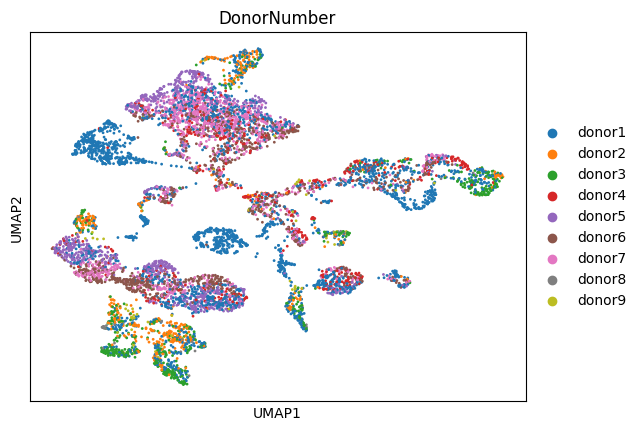

In [22]:
sc.pl.umap(ad_tmp, color="DonorNumber")

## Embeddings UMAP - AE

In [38]:
embeddings = get_data_embeddings(tensor_dataset=val_tensor_dataset, model=model)

d:\bioml\.venv\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


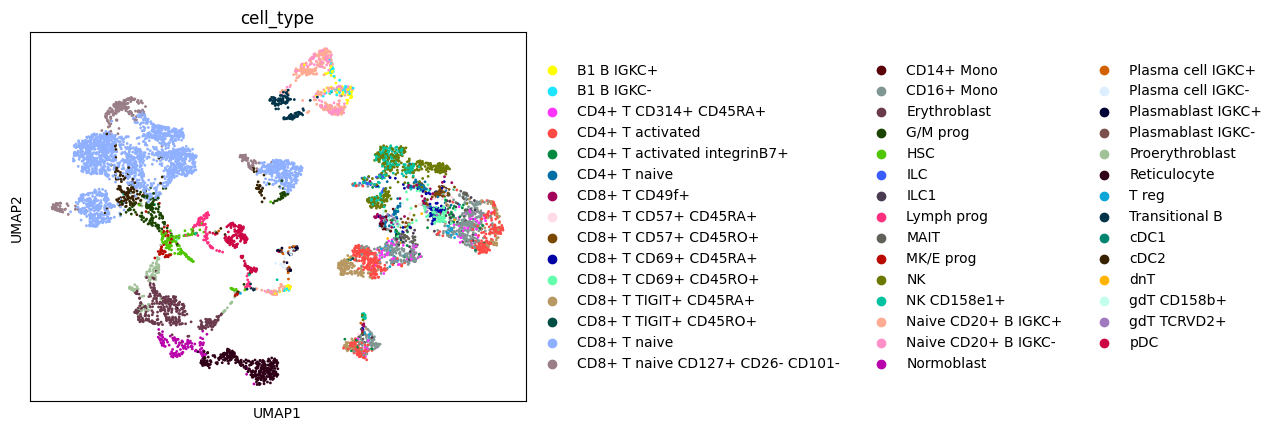

In [39]:
ad_tmp = ad.AnnData(
    X=embeddings.detach().numpy(),
    obs=pd.DataFrame(
        data={
            "cell_type": label_encoder.inverse_transform(val_celltype),
            "batch": val_batch_id,
        }
    ),
)
sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X")
sc.tl.umap(ad_tmp)
sc.pl.umap(ad_tmp, color="cell_type")

d:\bioml\.venv\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


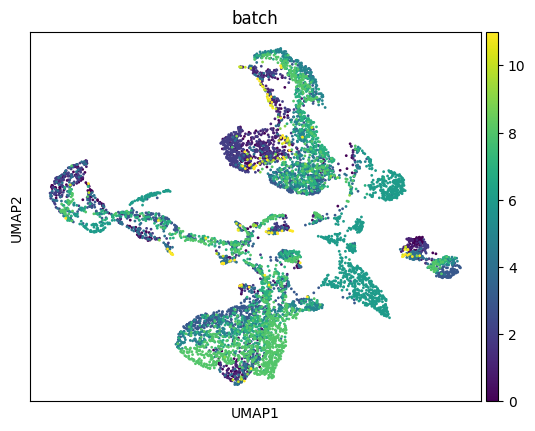

In [50]:
ad_tmp = ad.AnnData(
    X=embeddings.detach().numpy(),
    obs=pd.DataFrame(
        data={
            "cell_type": label_encoder.inverse_transform(val_celltype),
            "batch": val_batch_id,
        }
    ),
)
sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X")
sc.tl.umap(ad_tmp)
sc.pl.umap(ad_tmp, color="batch")

## PCA on emebddings - scatterplot

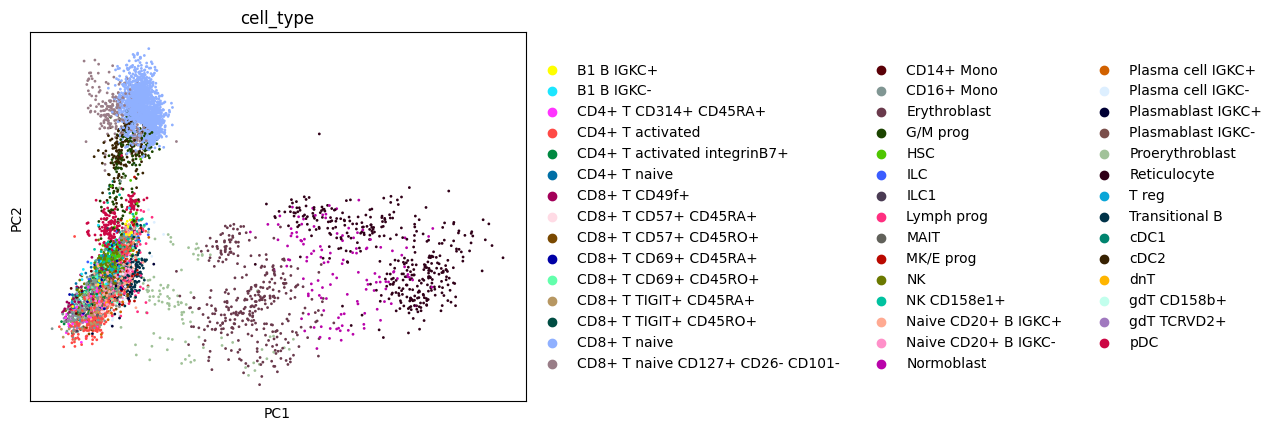

In [41]:
sc.pp.pca(ad_tmp, n_comps=10)
sc.pl.pca(ad_tmp, color="cell_type")

# Lighthinig version

In [25]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LinearLR, ExponentialLR, ChainedScheduler

In [26]:
class LightningAE(pl.LightningModule):
    def __init__(self, cfg):
        super(LightningAE, self).__init__()
        self.encoder = Encoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.dropout,
        )
        self.decoder = Decoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.dropout,
        )
        self.cfg = cfg

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.parameters(), lr=self.cfg.training.optimizer.lr)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.cfg.training.optimizer.lr,
            weight_decay=self.cfg.training.optimizer.weight_decay,
            eps=1e-8,
            betas=(0.9, 0.999),
            amsgrad=self.cfg.training.optimizer.amsgrad,
        )
        # scheduler = StepLR(optimizer, step_size=self.cfg.training.optimizer.step_size, gamma=self.cfg.training.optimizer.gamma)
        first_phase_scheduler = LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.cfg.training.optimizer.first_phase_iters,
        )
        second_phase_scheduler = ExponentialLR(
            optimizer, gamma=self.cfg.training.optimizer.second_phase_gamma
        )
        scheduler = ChainedScheduler([first_phase_scheduler, second_phase_scheduler])
        # return optimizer
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": self.cfg.training.optimizer.scheduler_frequency,
            },
        }

In [27]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "ae_1.0",
        "num_genes": 14087,
        "embedding_dim": 100,
        "latent_dim": 20,
        "dropout": 0.1,
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "lr": 1e-3,
            "weight_decay": 1e-3,
            "momentum": 0.9,
            "nesterov": True,
            "amsgrad": True,
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "n_epochs": 10,
    },
}

cfg = dict_to_namespace(cfg_dict)

NameError: name 'dict_to_namespace' is not defined

In [44]:
# # run tensorboard
# %load_ext tensorboard
# %tensorboard --logdir logs

In [45]:
trainer = pl.Trainer(
    max_epochs=cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger("logs", name=cfg.model.model_name),
)
model = LightningAE(cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 1.4 M  | train
1 | decoder | Decoder | 1.4 M  | train
--------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.427    Total estimated model params size (MB)


d:\bioml\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
d:\bioml\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1058/1058 [01:11<00:00, 14.79it/s, v_num=6, train_loss_step=0.0884, val_loss_step=0.103, val_loss_epoch=0.0901, train_loss_epoch=0.0918]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1058/1058 [01:11<00:00, 14.75it/s, v_num=6, train_loss_step=0.0884, val_loss_step=0.103, val_loss_epoch=0.0901, train_loss_epoch=0.0918]


## Embeddings UMAP - AE Lightning

In [47]:
embeddings = get_data_embeddings(tensor_dataset=val_tensor_dataset, model=model)

d:\bioml\.venv\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


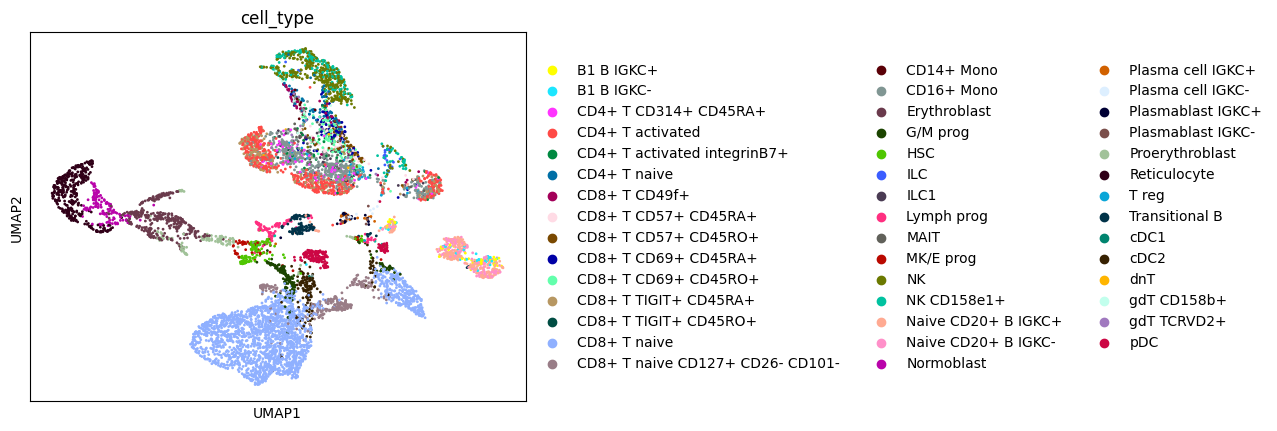

In [48]:
ad_tmp = ad.AnnData(
    X=embeddings.detach().numpy(),
    obs=pd.DataFrame(
        data={
            "cell_type": label_encoder.inverse_transform(val_celltype),
            "batch": val_batch_id,
        }
    ),
)
sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X")
sc.tl.umap(ad_tmp)
sc.pl.umap(ad_tmp, color="cell_type")

d:\bioml\.venv\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


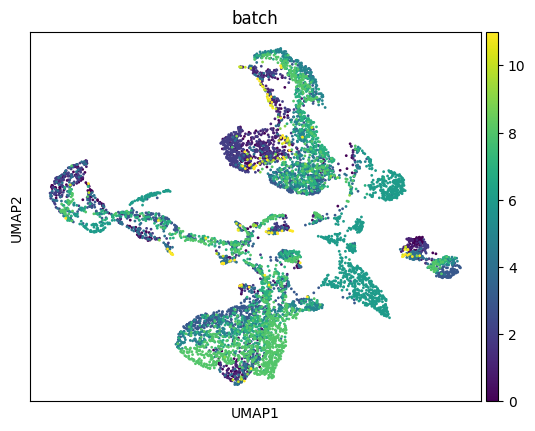

In [51]:
ad_tmp = ad.AnnData(
    X=embeddings.detach().numpy(),
    obs=pd.DataFrame(
        data={
            "cell_type": label_encoder.inverse_transform(val_celltype),
            "batch": val_batch_id,
        }
    ),
)
sc.pp.neighbors(ad_tmp, n_neighbors=10, use_rep="X")
sc.tl.umap(ad_tmp)
sc.pl.umap(ad_tmp, color="batch")

## PCA on emebddings - scatterplot Lightning

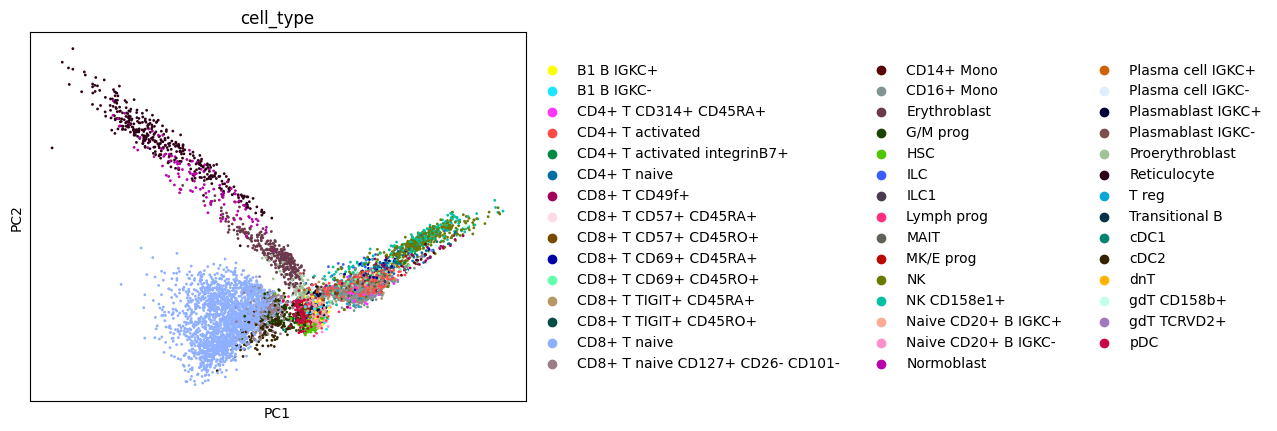

In [49]:
sc.pp.pca(ad_tmp, n_comps=10)
sc.pl.pca(ad_tmp, color="cell_type")

## RAE
[From Variational to Deterministic Autoencoders](https://arxiv.org/abs/1903.12436)